In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd
import random

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape, UpSampling2D, LeakyReLU, LayerNormalization, Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def mostrar_imagenes_generadas(modelo_generador, latent_dim=100, num_imagenes=4, image_size=(64, 64, 3)):
    """
    Genera y muestra imágenes lado a lado usando un modelo generador.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.
        image_size: tamaño esperado de las imágenes (solo usado si quieres validar forma).
    """
    # Generar vectores latentes aleatorios
    z = generateLatentDim(latent_dim, num_imagenes)

    # Generar imágenes con el modelo
    imagenes = modelo_generador.predict(z)

    # Mostrar imágenes en una fila
    fig, axes = plt.subplots(1, num_imagenes, figsize=(num_imagenes * 3, 3))
    for i, ax in enumerate(axes):
        ax.imshow((imagenes[i] + 1) / 2)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def generar_imagenes(modelo_generador, latent_dim=100, num_imagenes=4):
    """
    Genera imágenes en escala de grises usando un modelo generador y OpenCV.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.

    Returns:
        Array de imágenes en escala de grises con forma (num_imagenes, alto, ancho).
    """
    # Generar vectores latentes aleatorios
    z = np.random.normal(0, 1, (num_imagenes, latent_dim))

    # Generar imágenes con el modelo
    imagenes_rgb = modelo_generador.predict(z)

    # Asegurar que las imágenes están en el rango [0, 255] y tipo uint8
    imagenes_rgb = ((imagenes_rgb + 1)/2 * 255).astype(np.uint8)

    # Convertir a escala de grises con OpenCV
    imagenes_grises = np.array([cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY) for imagen in imagenes_rgb])

    return imagenes_grises


2025-10-28 14:48:05.292817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761662885.464145      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761662885.517395      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# GAN

## Defining Hiperparameters

In [3]:
import os

os.listdir("/kaggle/input")

['images']

In [4]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input'
folder = None#/kaggle/working/models/10_27_15:12/"

latent_dim_size = 100
batch_size = 128

In [5]:
# Latent dim generator
def generateLatentDim(latent_dim_size=latent_dim_size, batch_size= batch_size):
    return np.random.randn(batch_size, latent_dim_size)

# Discriminator
def build_discriminator():
    disc_input = Input(shape=(height, width, 3)) 
    x_disc = Conv2D(16, (3, 3), activation="relu", strides=1, padding="same")(disc_input)
    x_disc = Conv2D(32, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
    x_disc = MaxPooling2D()(x_disc)
    x_disc = Conv2D(64, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
    x_disc = Conv2D(128, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
    x_disc = Conv2D(256, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
    x_disc = Flatten()(x_disc)
    x_disc = Dense(512, activation="relu")(x_disc)
    # x_disc = Dense(512, activation="relu")(x_disc)
    classification = Dense(1, activation="sigmoid")(x_disc)
    
    return keras.Model(disc_input, classification, name="Discriminator")


# Bloque residual con upsampling
def residual_upsample_block(x, filters, kernel_size=3):
    # Shortcut: upsample + 1x1 conv
    shortcut = UpSampling2D(size=2, interpolation="nearest")(x)
    shortcut = Conv2D(filters, 1, padding="same", use_bias=False)(shortcut)

    # Rama principal
    y = UpSampling2D(size=2, interpolation="nearest")(x)
    y = Conv2D(filters, kernel_size, padding="same", use_bias=False)(y)
    # y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)

    y = Conv2D(filters, kernel_size, padding="same", use_bias=False)(y)
    # y = BatchNormalization()(y)

    out = Add()([y, shortcut])
    out = LeakyReLU(0.2)(out)
    return out

# Generador completo
def build_resGenerator(latent_dim=100):
    gen_input = Input(shape=(latent_dim,))

    # Proyección inicial
    x = Dense(4*4*1024)(gen_input)
    x = Reshape((4, 4, 1024))(x)

    # 8x8
    x = residual_upsample_block(x, filters=512)

    # 16x16
    x = residual_upsample_block(x, filters=256)

    # 32x32
    x = residual_upsample_block(x, filters=128)

    # 64x64
    x = residual_upsample_block(x, filters=64)

    # Salida RGB
    gen_image = Conv2DTranspose(3, (3, 3), activation="tanh", padding="same")(x)

    return keras.Model(gen_input, gen_image, name="resGenerator")

We define the autoencoder, encoder and decoder

In [34]:
if folder == None:
    generator = build_resGenerator()
    discriminator = build_discriminator()
else:
    generator = keras.models.load_model(folder + "Generator.keras")
    discriminator = keras.models.load_model(folder + "Discrimiator.keras")
generator.summary()

Model: "resGenerator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16384)     │  1,654,784 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4,      │          0 │ dense[0][0]       │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 8, 8,      │          0 │ reshape[0][0]     │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 512) │  4,718,592 │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8, 8, 512) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8,      │          0 │ reshape[0][0]     │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 512) │  2,359,296 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 512) │    524,288 │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 512) │          0 │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 512) │          0 │ add[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │  1,179,648 │ up_sampling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    589,824 │ leaky_re_lu_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    131,072 │ up_sampling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ conv2d_5[0][0],   │
│                     │ 256)              │            │ conv2d_3[0][0]  

 Total params: 11,753,155 (44.83 MB)

 Trainable params: 11,753,155 (44.83 MB)

 Non-trainable params: 0 (0.00 B)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [35]:
# Función personalizada para escalar entre -1 y 1
def scale_minus1_to_1(img):
    return img / 127.5 - 1.0

datagen = ImageDataGenerator(preprocessing_function=scale_minus1_to_1)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    shuffle=True
)


Found 63565 images belonging to 1 classes.


## Train

In [36]:
# Compilar discriminador con binary_crossentropy
opt_d = keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.5)
opt_g = keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.5)
discriminator.trainable = True
discriminator.compile(optimizer=opt_d, loss='binary_crossentropy', metrics=['accuracy'])

# Congelar discriminador para entrenar el generador
discriminator.trainable = False
gan_input = tf.keras.layers.Input(shape=(latent_dim_size,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=opt_g, loss='binary_crossentropy')

Epoch 0 | D loss: 0.7762 | D acc: 0.1465 | G loss: 0.5260
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


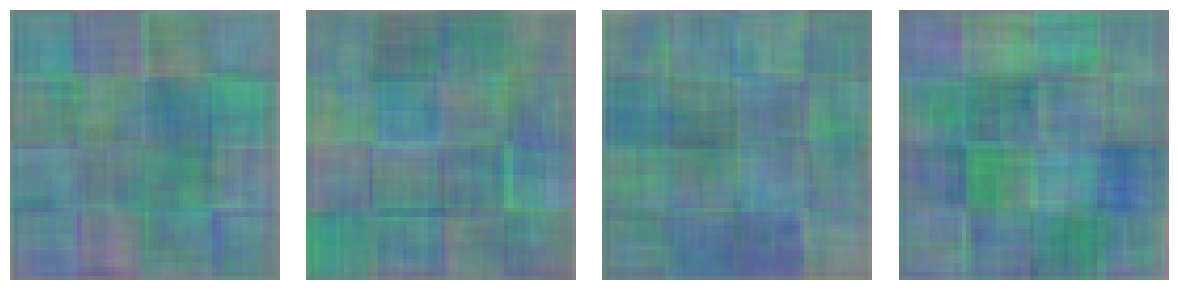

Epoch 100 | D loss: 0.5310 | D acc: 0.5932 | G loss: 0.6612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


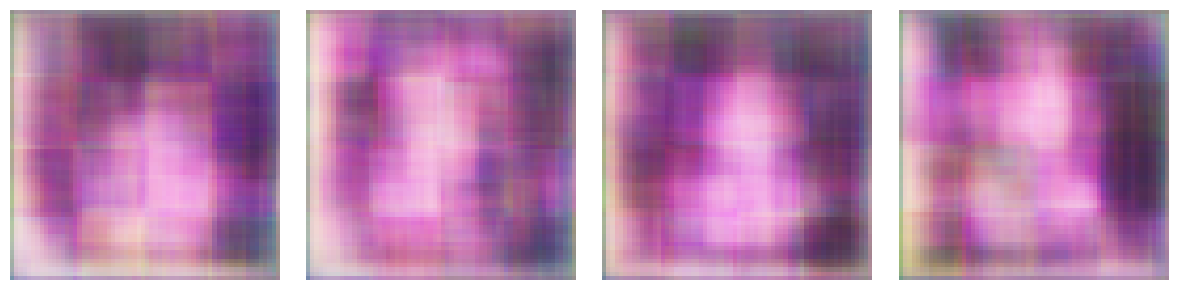

Epoch 200 | D loss: 0.4593 | D acc: 0.7212 | G loss: 0.7205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


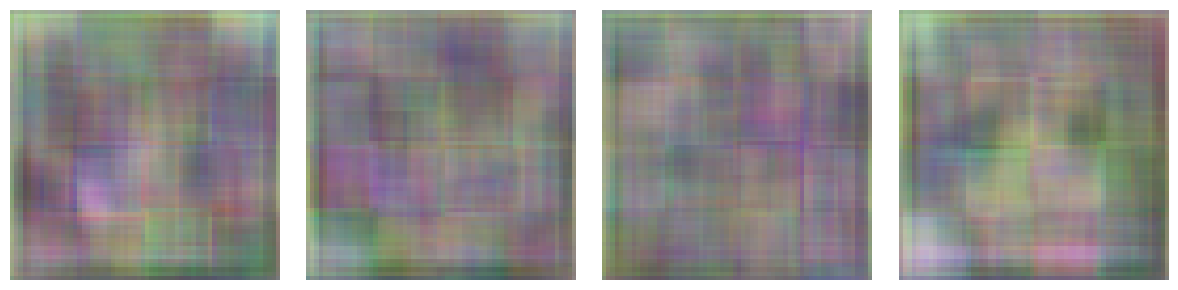

Epoch 300 | D loss: 0.3932 | D acc: 0.8109 | G loss: 0.7949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


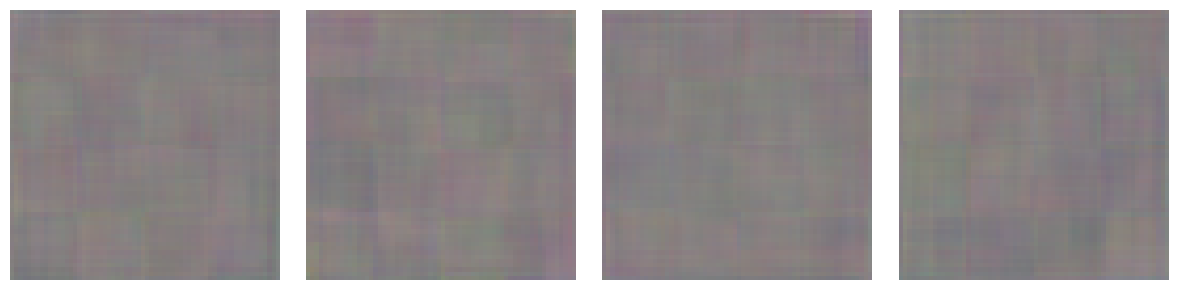

Epoch 400 | D loss: 0.3160 | D acc: 0.8580 | G loss: 1.1328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


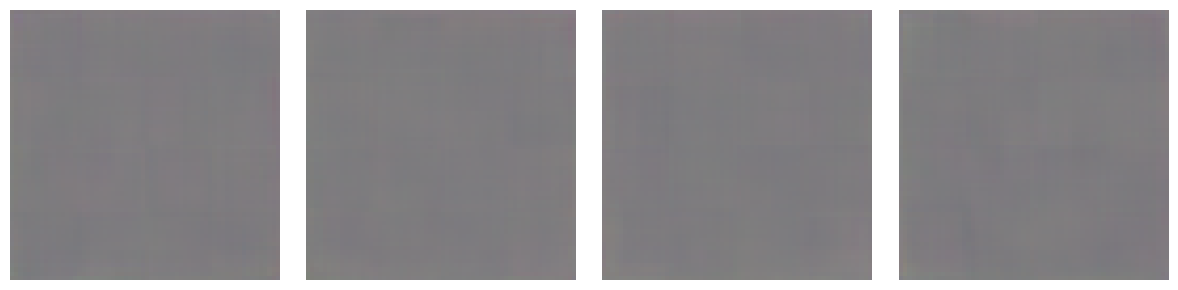

Epoch 500 | D loss: 0.2552 | D acc: 0.8862 | G loss: 1.7220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


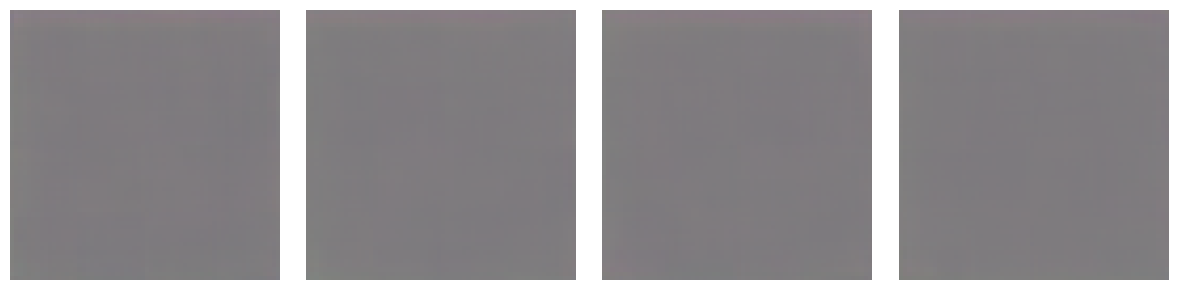

Epoch 600 | D loss: 0.2133 | D acc: 0.9051 | G loss: 2.2925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


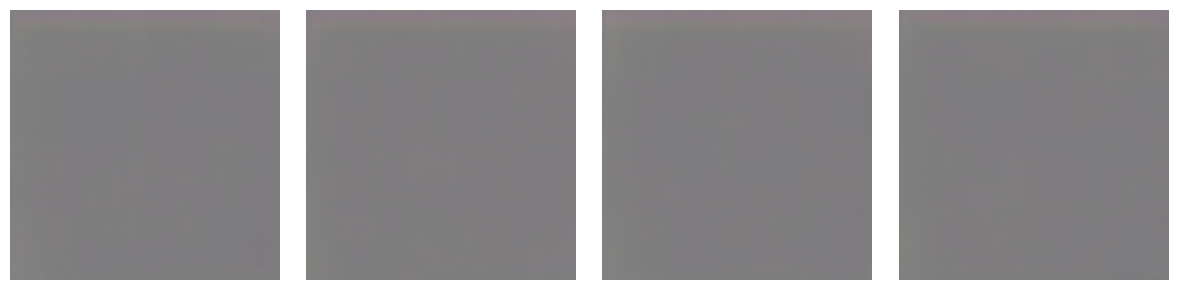

Epoch 700 | D loss: 0.3694 | D acc: 0.8980 | G loss: 2.4702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


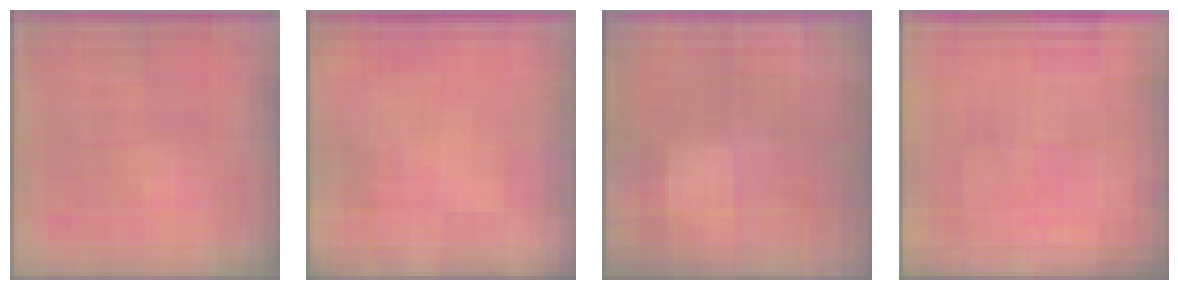

Epoch 800 | D loss: 0.3521 | D acc: 0.9048 | G loss: 2.4059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


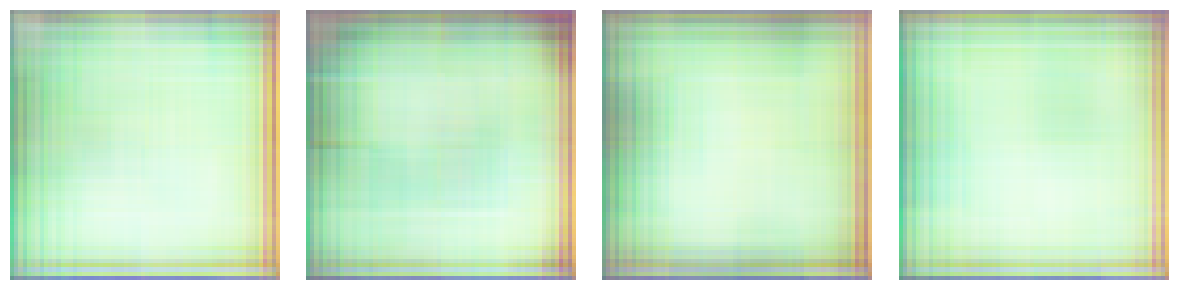

Epoch 900 | D loss: 0.3898 | D acc: 0.8627 | G loss: 2.2766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


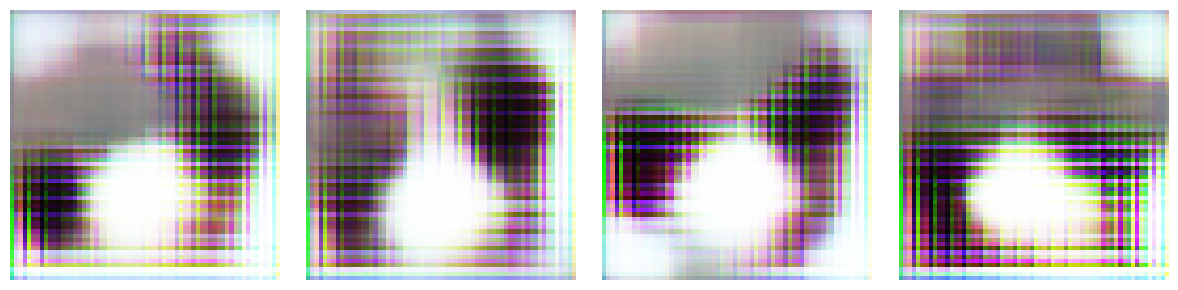

Epoch 1000 | D loss: 0.4178 | D acc: 0.8379 | G loss: 2.1425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


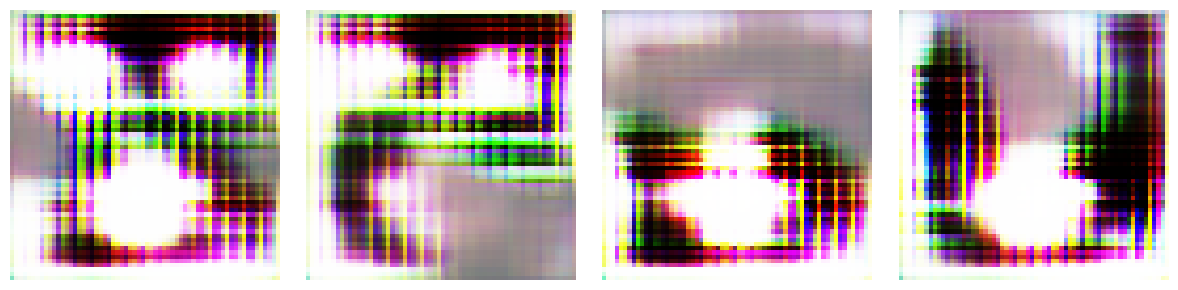

Epoch 1100 | D loss: 0.4419 | D acc: 0.8123 | G loss: 2.0274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


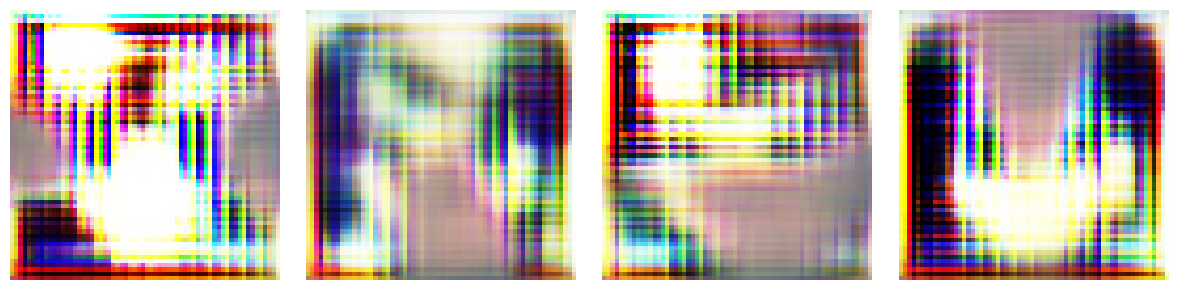

Epoch 1200 | D loss: 0.4619 | D acc: 0.7912 | G loss: 1.9247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


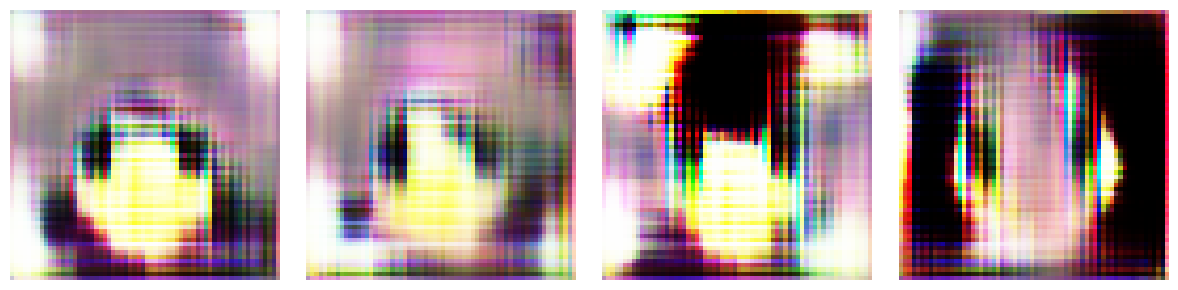

Epoch 1300 | D loss: 0.4813 | D acc: 0.7660 | G loss: 1.8346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


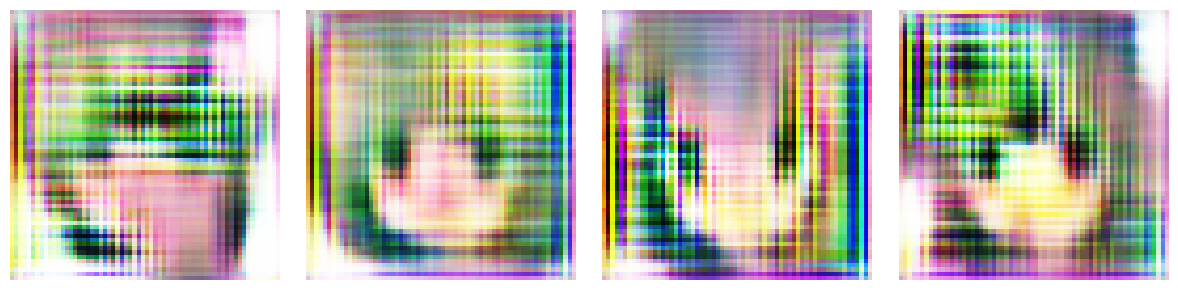

Epoch 1400 | D loss: 0.4990 | D acc: 0.7384 | G loss: 1.7568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


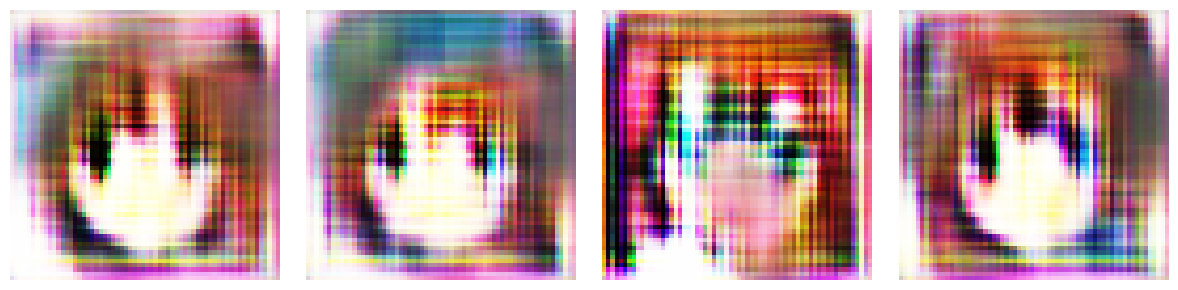

Epoch 1500 | D loss: 0.5131 | D acc: 0.7178 | G loss: 1.6885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


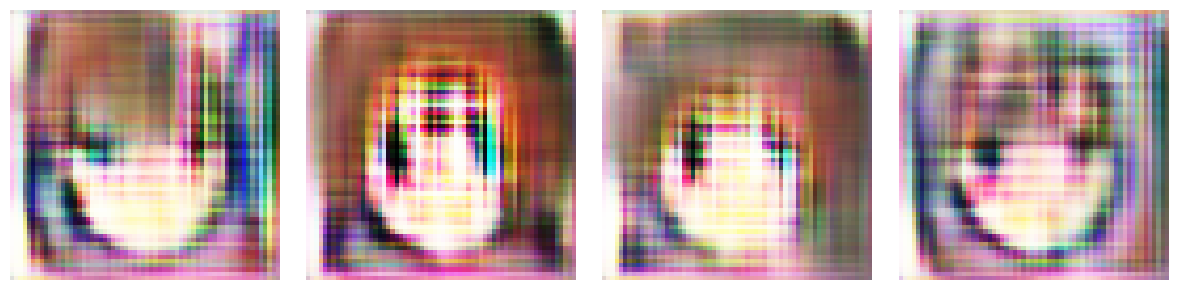

Epoch 1600 | D loss: 0.5229 | D acc: 0.7126 | G loss: 1.6292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


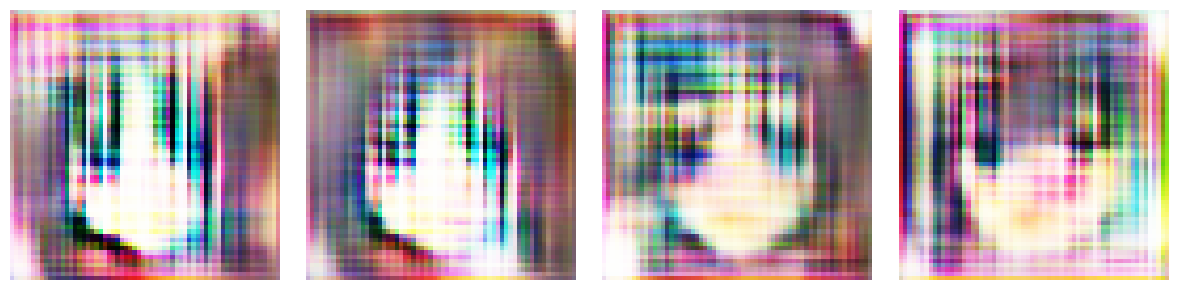

Epoch 1700 | D loss: 0.5326 | D acc: 0.7034 | G loss: 1.5794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


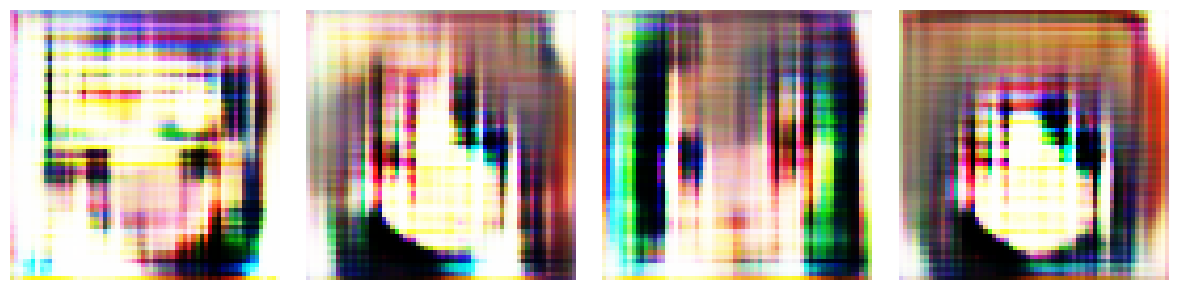

Epoch 1800 | D loss: 0.5415 | D acc: 0.6944 | G loss: 1.5350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


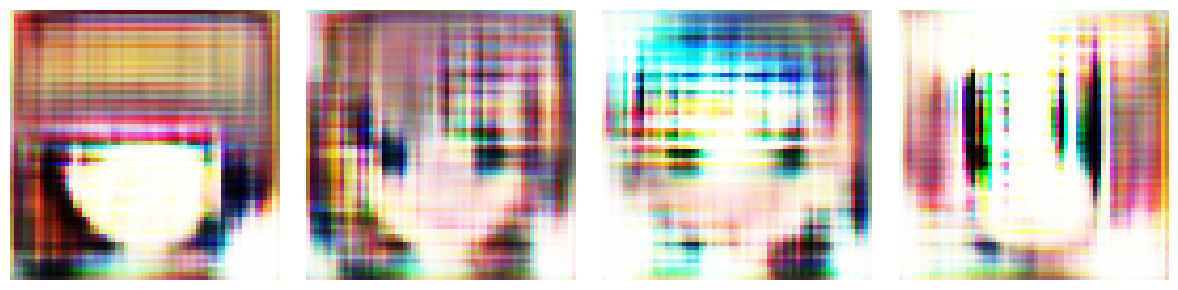

Epoch 1900 | D loss: 0.5492 | D acc: 0.6877 | G loss: 1.4950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


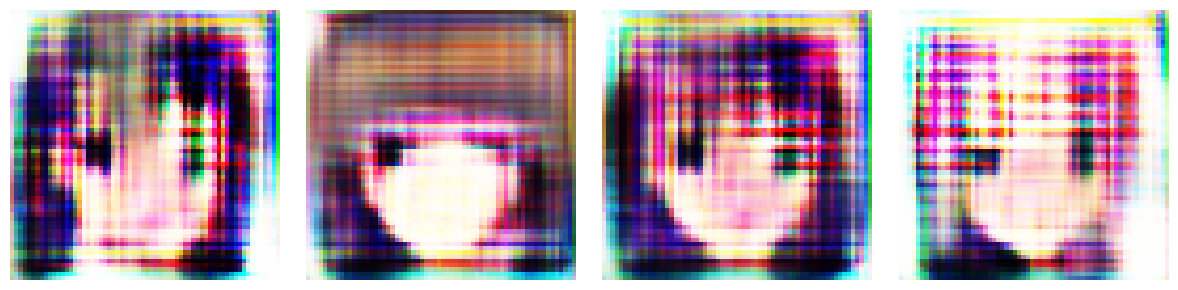

Epoch 2000 | D loss: 0.5557 | D acc: 0.6830 | G loss: 1.4592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


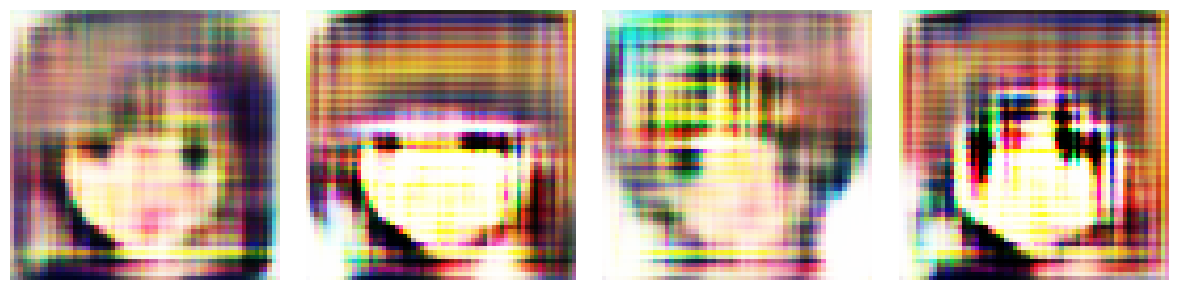

Epoch 2100 | D loss: 0.5622 | D acc: 0.6767 | G loss: 1.4266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


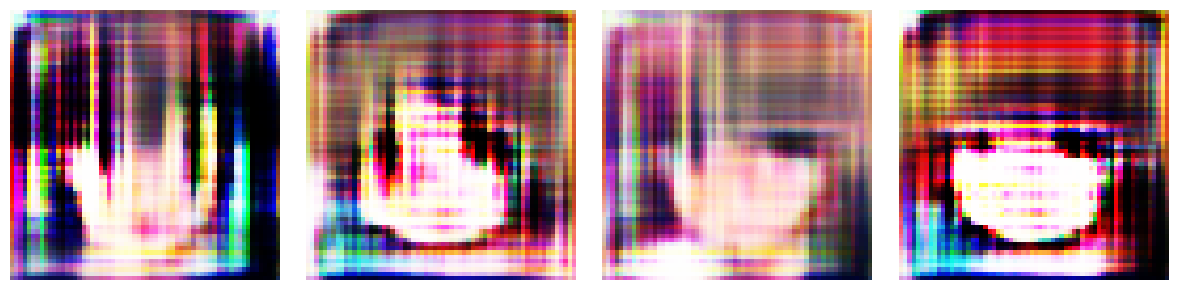

Epoch 2200 | D loss: 0.5679 | D acc: 0.6729 | G loss: 1.3975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


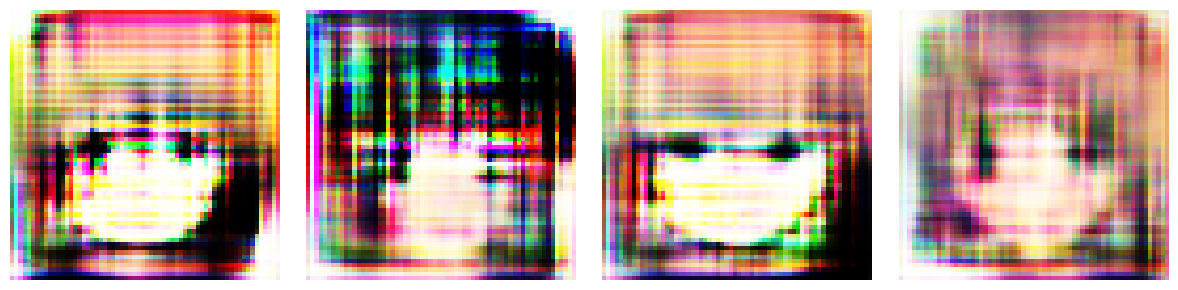

Epoch 2300 | D loss: 0.5728 | D acc: 0.6719 | G loss: 1.3709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


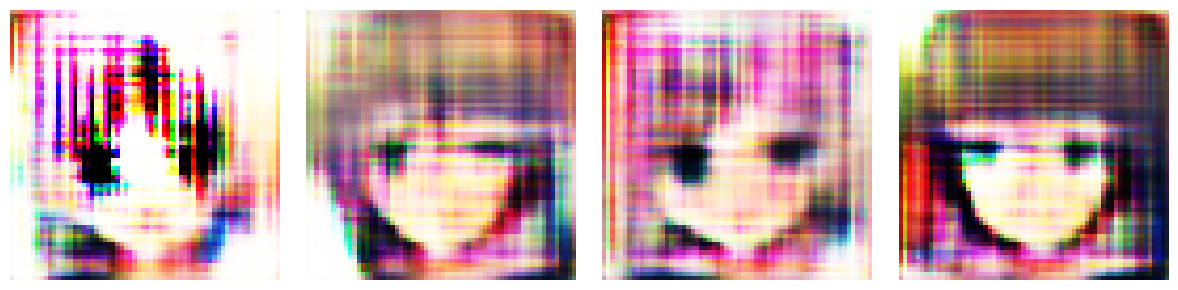

Epoch 2400 | D loss: 0.5772 | D acc: 0.6717 | G loss: 1.3465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


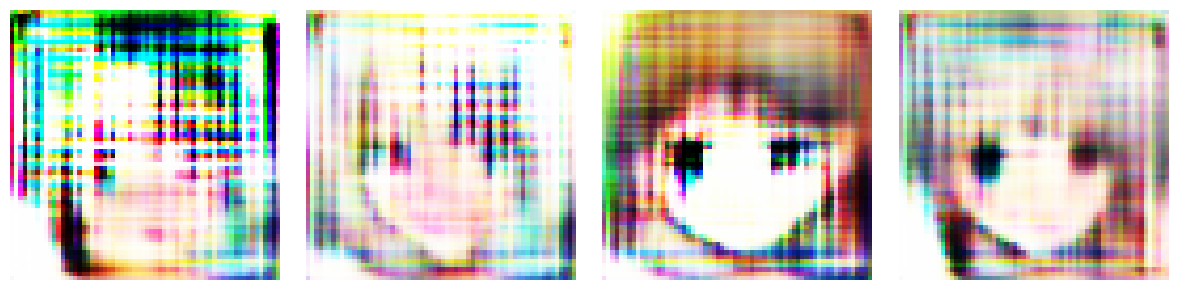

Epoch 2500 | D loss: 0.5813 | D acc: 0.6710 | G loss: 1.3238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


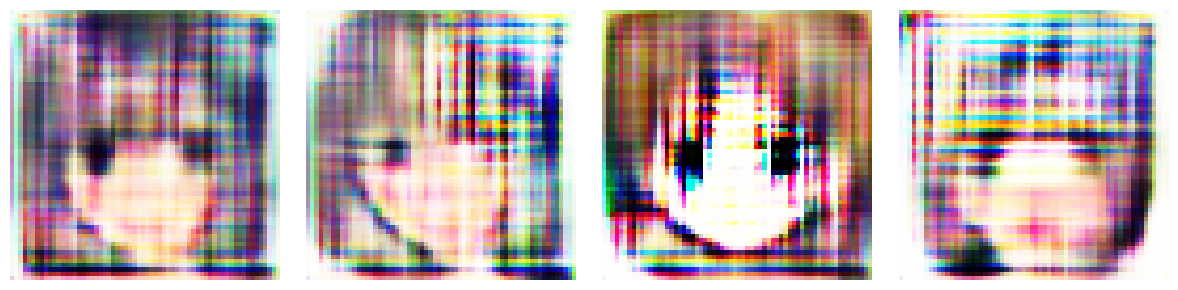

Epoch 2600 | D loss: 0.5851 | D acc: 0.6698 | G loss: 1.3024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


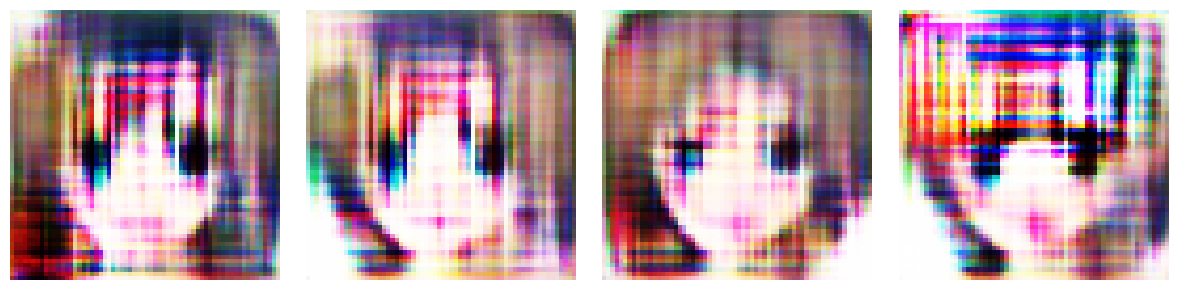

Epoch 2700 | D loss: 0.5886 | D acc: 0.6689 | G loss: 1.2830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


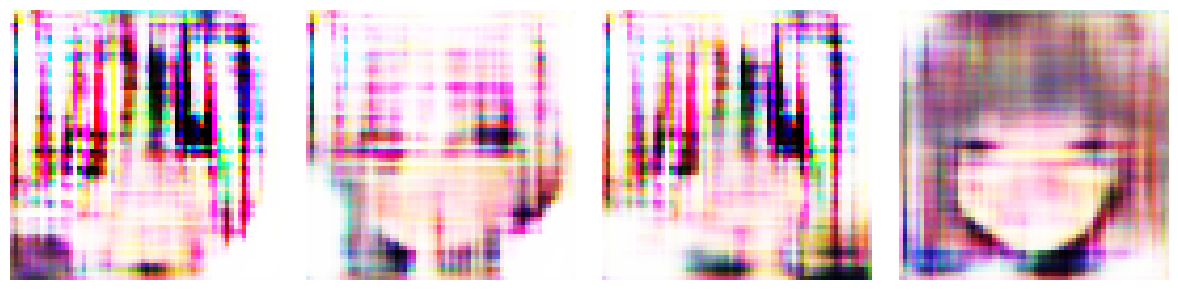

Epoch 2800 | D loss: 0.5918 | D acc: 0.6680 | G loss: 1.2648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


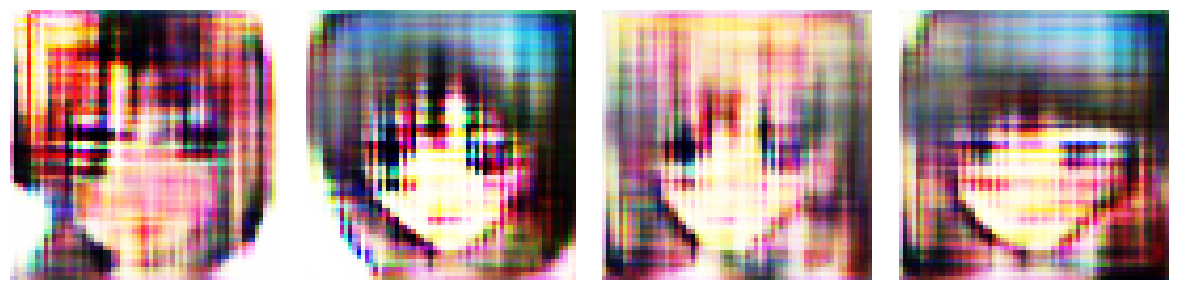

Epoch 2900 | D loss: 0.5948 | D acc: 0.6667 | G loss: 1.2483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


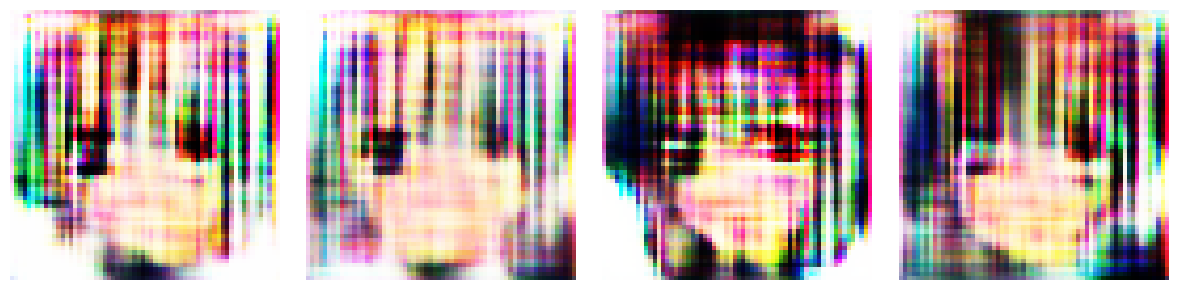

Epoch 3000 | D loss: 0.5975 | D acc: 0.6662 | G loss: 1.2330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


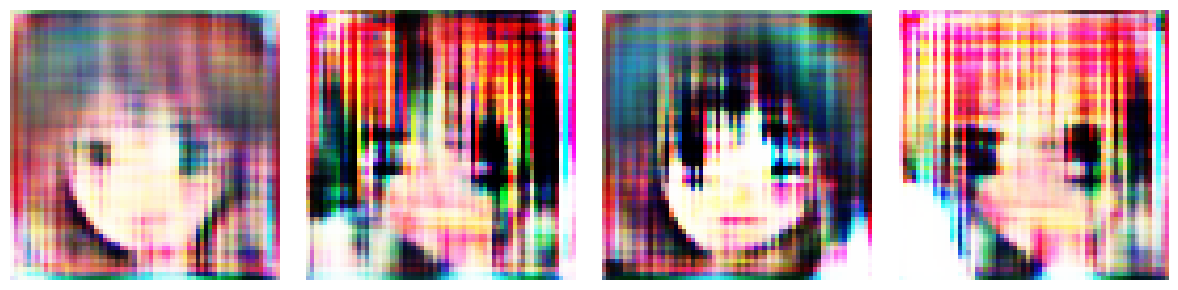

Epoch 3100 | D loss: 0.5995 | D acc: 0.6689 | G loss: 1.2192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


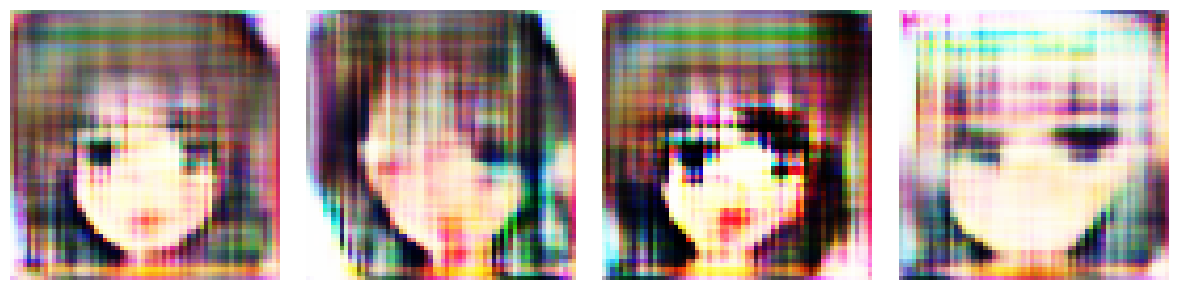

Epoch 3200 | D loss: 0.6020 | D acc: 0.6682 | G loss: 1.2055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


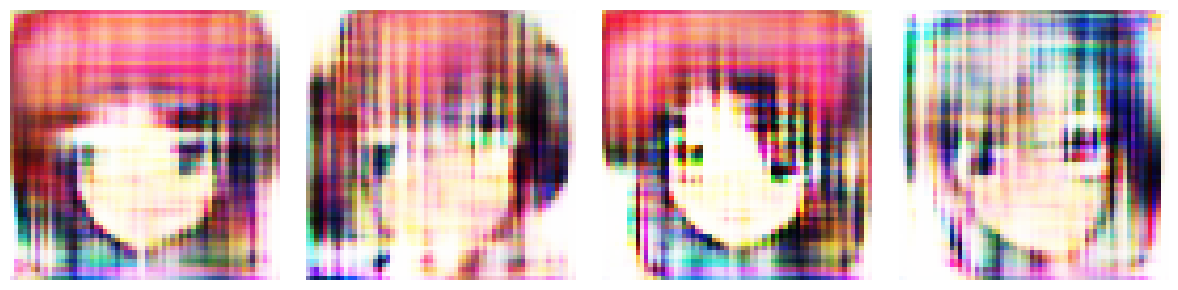

Epoch 3300 | D loss: 0.6042 | D acc: 0.6683 | G loss: 1.1927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


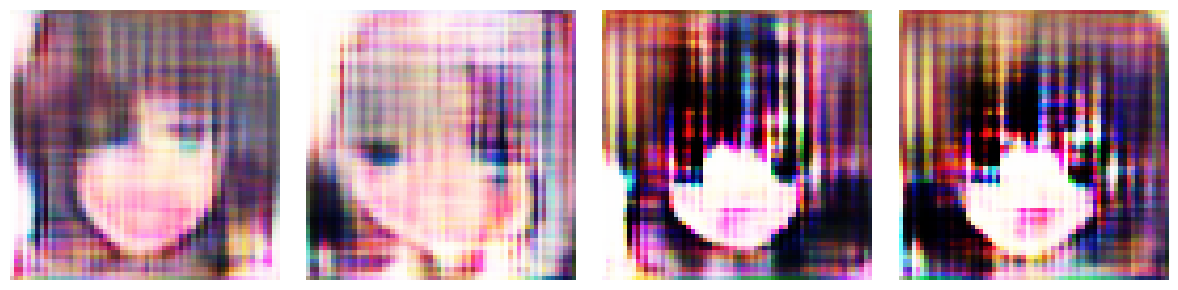

Epoch 3400 | D loss: 0.6060 | D acc: 0.6696 | G loss: 1.1808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


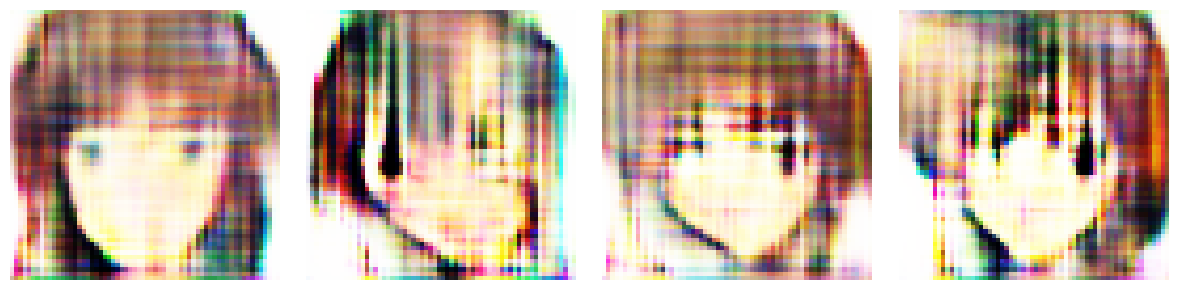

Epoch 3500 | D loss: 0.6076 | D acc: 0.6711 | G loss: 1.1700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


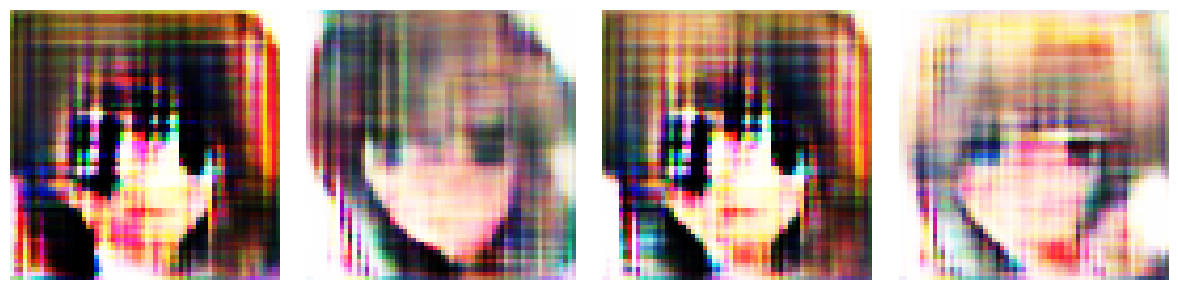

Epoch 3600 | D loss: 0.6092 | D acc: 0.6722 | G loss: 1.1597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


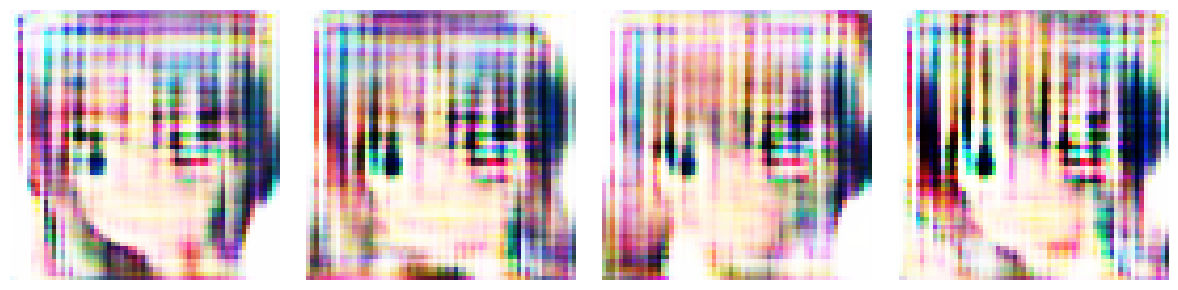

Epoch 3700 | D loss: 0.6107 | D acc: 0.6731 | G loss: 1.1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


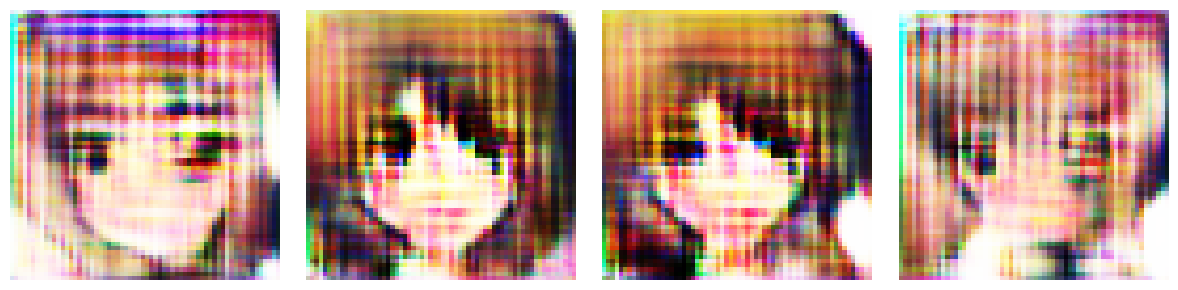

Epoch 3800 | D loss: 0.6121 | D acc: 0.6733 | G loss: 1.1409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


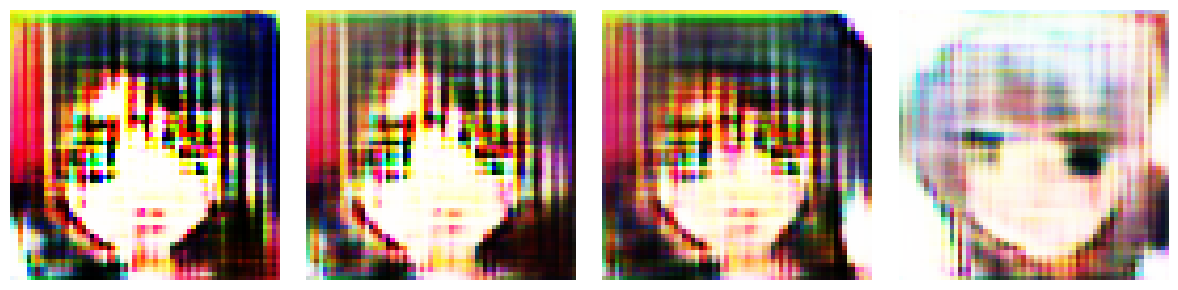

Epoch 3900 | D loss: 0.6137 | D acc: 0.6722 | G loss: 1.1318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


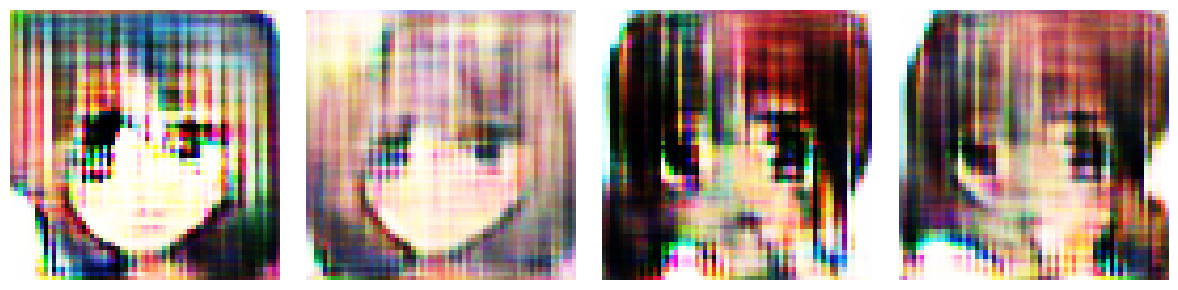

Epoch 4000 | D loss: 0.6151 | D acc: 0.6719 | G loss: 1.1231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


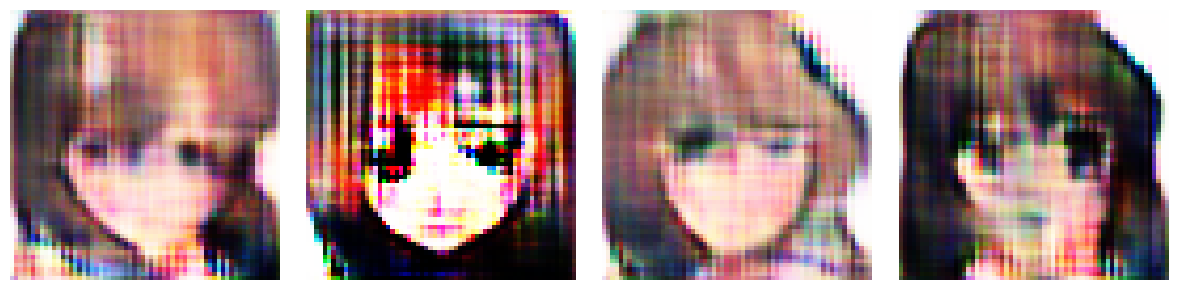

Epoch 4100 | D loss: 0.6163 | D acc: 0.6727 | G loss: 1.1153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


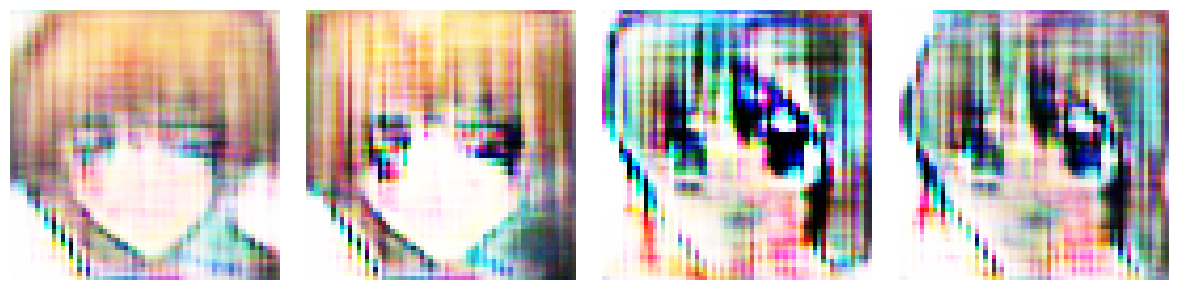

Epoch 4200 | D loss: 0.6176 | D acc: 0.6720 | G loss: 1.1077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


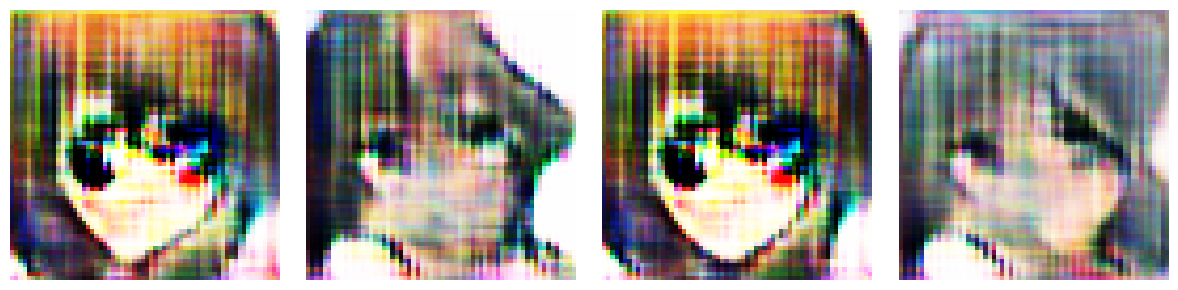

Epoch 4300 | D loss: 0.6189 | D acc: 0.6708 | G loss: 1.1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


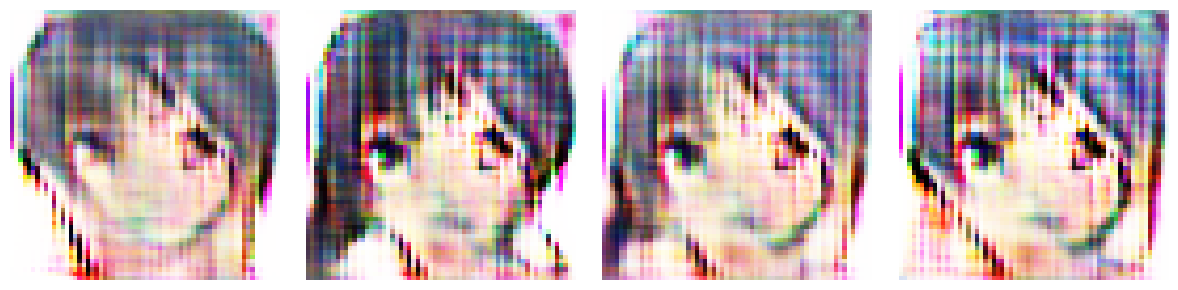

In [ ]:
epochs = 10000

# Bucle de entrenamiento
for epoch in range(epochs):
    # === Entrenar discriminador ===
    # 1. Obtener imágenes reales del generador
    real_images = next(train_generator)[0]

    # 2. Generar imágenes falsas
    z = generateLatentDim()
    fake_images = generator(z, training=False)

    # 3. Crear etiquetas: 1 para reales, 0 para falsas
    real_labels = np.ones((real_images.shape[0], 1))
    fake_labels = np.zeros((fake_images.shape[0], 1))

    # # 4. Combinar y mezclar
    # combined_images = np.concatenate([real_images, fake_images], axis=0)
    # combined_labels = np.concatenate([real_labels, fake_labels], axis=0)

    # indices = np.arange(combined_images.shape[0])
    # np.random.shuffle(indices)

    # shuffled_images = combined_images[indices]
    # shuffled_labels = combined_labels[indices]

    # 5. Entrenar discriminador con batch mezclado (solo una de cada 2)
    # discriminator.trainable = True
    # d_loss = discriminator.train_on_batch(shuffled_images, shuffled_labels)
    if epoch % 2 == 0:
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # === Entrenar generador ===
    z = generateLatentDim()
    trick_labels = np.ones((batch_size, 1))  # queremos que el discriminador crea que son reales
    discriminator.trainable = False
    g_loss = gan.train_on_batch(z, trick_labels)

    # Mostrar progreso
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D loss: {d_loss[0]:.4f} | D acc: {d_loss[1]:.4f} | G loss: {g_loss:.4f}")
        mostrar_imagenes_generadas(generator)


### Comprobar resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


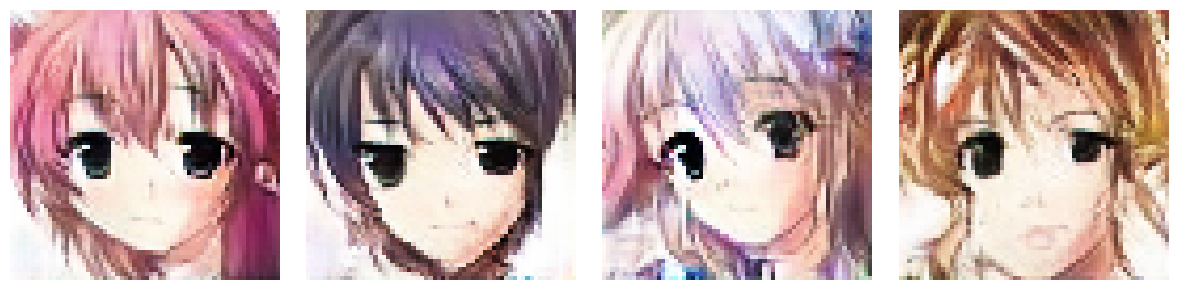

In [7]:
generator = keras.models.load_model("/kaggle/working/models/10_27_15:12/Generator.keras")
mostrar_imagenes_generadas(generator)

In [ ]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
os.makedirs("models/"+timestamp, exist_ok=True)
generator_path = f"models/{timestamp}/Generator.keras"
discriminator_path = f"models/{timestamp}/Discrimiator.keras"

# Save the model
generator.save(generator_path)
discriminator.save(discriminator_path)

In [ ]:
def guardar_imagenes_en_csv(imagenes_grises):
    """
    Guarda imágenes en escala de grises en un CSV con columnas: id, 0, ..., 4095.

    Args:
        imagenes_grises: array de forma (200, 64, 64) con imágenes en escala de grises.
        nombre_csv: nombre del archivo CSV a guardar.
    """
    num_imagenes = imagenes_grises.shape[0]
    pixeles_por_imagen = imagenes_grises.shape[1] * imagenes_grises.shape[2]

    # Aplanar cada imagen a un vector de 4096 elementos
    imagenes_aplanadas = imagenes_grises.reshape(num_imagenes, pixeles_por_imagen)

    # Crear DataFrame con columnas: id, 0, ..., 4095
    columnas = ['ID'] + [str(i) for i in range(pixeles_por_imagen)]
    datos = np.column_stack((np.arange(1, num_imagenes + 1), imagenes_aplanadas))
    df = pd.DataFrame(datos, columns=columnas)

    # Guardar en CSV
    os.makedirs("submissions", exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
    df.to_csv("submissions/ResGAN_"+timestamp+".csv", index=False)


guardar_imagenes_en_csv(generar_imagenes(generator, num_imagenes=200))